In [2]:
pygpstruct_location = '/xvdb/pygpstruct'
#pygpstruct_location = '/home/sb358/pygpstruct-develop'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import sys
sys.path.append(pygpstruct_location + '/src/') # replace by your path to .py files
np.set_printoptions(precision=3)

import util_experiments # while changing code here, to make sure it autoreloads
import slice_sample_hyperparameters
import prepare_from_data_chain
import learn_predict
import kernels
import util

# Dataset

In [26]:
!cd /xvdb/pygpstruct/data/protein/
!wget http://www.princeton.edu/~jzthree/datasets/ICML2014/cb513+profile_split1.npy.gz

--2015-10-09 14:36:59--  http://www.princeton.edu/~jzthree/datasets/ICML2014/cb513+profile_split1.npy.gz
Resolving www.princeton.edu (www.princeton.edu)... 140.180.223.42
Connecting to www.princeton.edu (www.princeton.edu)|140.180.223.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9761359 (9.3M) [application/x-gzip]
Saving to: ‘cb513+profile_split1.npy.gz’

cb513+profile_split 100%[=====================>]   9.31M  2.90MB/s   in 3.3s   

2015-10-09 14:37:02 (2.83 MB/s) - ‘cb513+profile_split1.npy.gz’ saved [9761359/9761359]



In [45]:
import numpy as np
x = np.load('/xvdb/pygpstruct/data/protein/cb513+profile_split1.npy')

In [46]:
x.shape

(514, 39900)

In [47]:
y=x.reshape((514,700,-1))
y.shape

(514, 700, 57)

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>


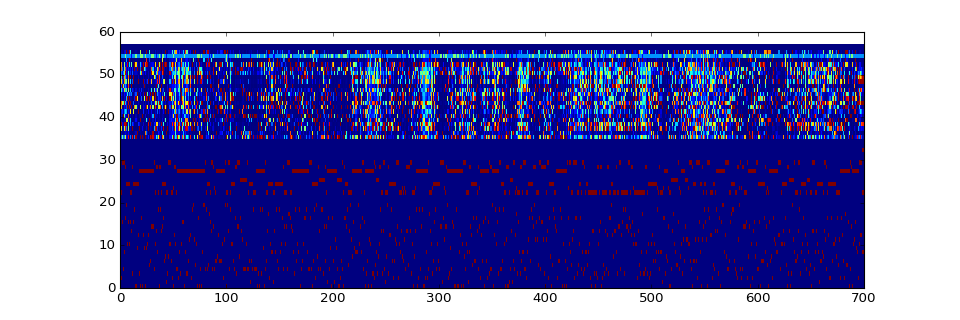

In [16]:
fig, ax = plt.subplots(figsize=(12,4));
ax.pcolor(y[513,:].T)
#plt.show()

In [13]:
protein = 0 # exmaple protein index
assert y[protein, -1, 21] == 1 # last aa label is marked NoSeq (and probably quite a few before that)
assert y[protein, -1, 0] == 0 #

assert y[protein, -1, 30] == 1 # last seq structure label is NoSeq
assert y[protein, -1, 28] == 0 # last seq structure label is NoSeq

assert y[protein, -1, 56] == 1 # last sequence profile feature has just a 1 in last position to signal no info here

print(y[0:, :, 33:35].min() )

0.0


In [17]:


def one_hot_to_index(a): # assume [n, one-hot index]
    result = np.empty(a.shape[0], dtype=np.int)
    sequence = np.arange(a.shape[1])
    for n in range(a.shape[0]):
        result[n] = a[n].dot(sequence)
    return result
a = y[protein, :31, range(22,30)].T
print(a.shape)
print(one_hot_to_index(a))
print(a)

(31, 8)
[0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 7 7 7 7 2 2 2]
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0. 

# Make data structure from J Zhou file


In [48]:
data_folder = '/xvdb/pygpstruct/data/protein'

class data_class:

    def one_hot_to_index(a): # assume [n, one-hot index]
        result = np.empty(a.shape[0], dtype=np.int)
        sequence = np.arange(a.shape[1])
        for n in range(a.shape[0]):
            result[n] = a[n].dot(sequence)
        return result

    def __init__(self):
        x = np.load('/xvdb/pygpstruct/data/protein/cb513+profile_split1.npy').reshape((514,700,-1))
        self.N = x.shape[0] # 514
        self.n_labels = 8 # we're not predicting end of sequence label
        self.object_size = np.empty((self.N), dtype=np.int)
        x_list = [] # will accumulate sparse matrices containing X data

        for n in range(self.N):
            non_zero_indices = np.nonzero(x[n, :, 21] == 1)[0] # check whether AA is NoSeq
            if non_zero_indices.size == 0: # protein chains #512 and 513 have size 700 (fill out entire row)
                self.object_size[n] = 700
            else:
                self.object_size[n] = non_zero_indices[0]

        self.n_points = self.object_size.sum()
        self.X = [] # initially accumulate everything in lists, then concatenate all # eventually shape like np.empty((self.n_points, 21-0+56-35))
        # we'll keep features 0:21 (AA identity), 35:56 (sequence profile, excluding end of sequence marker at position 56)
        x_indices_extract = list(range(0,21))
        x_indices_extract.extend(list(range(35,56)))
        self.Y = []
        self.unaries=[]
        
        for n in range(self.N):
            self.X.append(x[n, :self.object_size[n], x_indices_extract])
            self.Y.append(data_class.one_hot_to_index(x[n, :self.object_size[n], range(22,30)].T))
            self.unaries.append(np.zeros((self.object_size[n], self.n_labels), dtype=np.int))

        self.X = np.hstack(self.X)

        f_index_max = 0 # contains largest index in f
        for yt in range(self.n_labels):
            for n in range(self.N):
                for t in range(self.object_size[n]):
                    self.unaries[n][t, yt] = f_index_max
                    f_index_max = f_index_max + 1

        self.binaries = np.arange(f_index_max, f_index_max + self.n_labels**2).reshape((self.n_labels, self.n_labels), order='F')
        
data = data_class()

In [53]:
data.Y[13]


array([0, 5, 5, 5, 5, 5, 5, 7, 6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0])

In [16]:
data.unaries[0].shape

(67, 8)

In [ ]:
import dataset_chain

In [52]:
import pickle
with open(data_folder + '/dataset.pickle', 'rb') as f:
    t = pickle.load(file=f)

In [55]:
with open(data_folder + '/dataset.pickle', 'wb') as f:
    pickle.dump(t, f)

# Test if this runs

In [1]:
pygpstruct_location = '/xvdb/pygpstruct'
#pygpstruct_location = '/home/sb358/pygpstruct-develop'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import sys
sys.path.append(pygpstruct_location + '/src/') # replace by your path to .py files
np.set_printoptions(precision=3)

import util_experiments # while changing code here, to make sure it autoreloads
import slice_sample_hyperparameters
import prepare_from_data_chain
import learn_predict
import kernels
import util

In [4]:
%load_ext memory_profiler

In [66]:
%%memit  
prepare_from_data_chain.learn_predict_gpstruct_wrapper(
    data_indices_train=np.arange(0,50), 
    data_indices_test=np.arange(50,75),
    task='protein',
    data_folder='/xvdb/pygpstruct/data/protein/',
    result_prefix='/tmp/pygpstruct_protein/',
    console_log=True, # log to console as well as to file ?
    n_samples=101,
    prediction_thinning=100, # how often (in terms of MCMC iterations) to carry out prediction, ie compute f*|f and p(y*)
    prediction_verbosity=None,
    lhp_init={'unary': np.log(1), 'binary': np.log(0.01), 'jitter' : np.log(1e-4), 'length_scale' : np.log(5)},
    lhp_prior = lambda _lhp_target : 0 if (np.all(_lhp_target>np.log(1e-3)) and np.all(_lhp_target<np.log(1e2))) else np.NINF,
    hp_sampling_thinning=1, 
    hp_sampling_mode=None,
    kernel = kernels.kernel_exponential,
    random_seed=0,
    stop_check=None,
    native_implementation=False,
    log_f=False,
    no_hotstart = True
    )

2015-11-19 14:01:22,882Z - INFO - learn_predict_gpstruct started with arguments: {'prediction_thinning': 100, 'result_prefix': '/tmp/pygpstruct_protein/', 'prepare_from_data': <function learn_predict_gpstruct_wrapper.<locals>.<lambda> at 0x7fbf6cec42f0>, 'stop_check': None, 'lhp_gset': (<function default_get_lhp_target at 0x7fbf6cf45950>, <function default_set_lhp_target at 0x7fbf6cf456a8>), 'hp_sampling_mode': None, 'prior': 1, 'random_seed': 0, 'lhp_prior': <function <lambda> at 0x7fbf71f8d6a8>, 'prediction_verbosity': None, 'kernel': <function kernel_exponential at 0x7fbf74f76ae8>, 'no_hotstart': True, 'n_f_star': 0, 'hp_sampling_thinning': 1, 'lhp_init': {'jitter': -9.2103403719761818, 'length_scale': 1.6094379124341003, 'binary': -4.6051701859880909, 'unary': 0.0}, 'console_log': True, 'log_f': False, 'n_samples': 101, 'lhp_update': None}
2015-11-19 14:01:23,150Z - INFO - source code status: Local changes:
 M src/chain_forwards_backwards_logsumexp.py
 M src/kernels.py
 M src/learn

KeyboardInterrupt: 

In [2]:
import scipy.stats
import kernels
import copy
import numba

@numba.jit
def set_lhp_target_ard(lhp_, lhp_target):
    """smartly sets dict values from array
    lhp_ : dict
    lhp_target : hp vector
    return value: a modified copy of lhp_
    
    lhp_target has length 1+1 (variances) + 1(binary)
    """
    new_lhp = copy.deepcopy(lhp_)
    new_lhp["variances"] = np.empty(42)
    new_lhp["variances"][0:21] = np.ones(21)*lhp_target[0]
    new_lhp["variances"][21:42] = np.ones(21)*lhp_target[1]
    new_lhp["binary"] = lhp_target[2]
    return new_lhp

@numba.jit
def get_lhp_target_ard(lhp_dict):
    """creates array from dict"""
    lhp_target = np.empty((2+1))
    lhp_target[0] = lhp_dict["variances"][0]
    lhp_target[1] = lhp_dict["variances"][1]
    lhp_target[2] = lhp_dict["binary"]
    return lhp_target
hyperprior_ard_ub = lambda x : scipy.stats.multivariate_normal(mean=np.zeros(8), cov=np.log(2)).logpdf(x)
hyperprior_ard_ub_narrow = lambda x : scipy.stats.multivariate_normal(mean=np.zeros(8), cov=0.3).logpdf(x)


In [3]:
print(set_lhp_target_ard({}, np.arange(3)))
print(get_lhp_target_ard({'variances' : np.log(np.ones((42))), 'binary': 0}))

{'variances': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.]), 'binary': 2}
[ 0.  0.  0.]


In [15]:
%%memit  
prepare_from_data_chain.learn_predict_gpstruct_wrapper(
    data_indices_train=np.arange(0,20), 
    data_indices_test=np.arange(10,20),
    task='protein',
    data_folder='/xvdb/pygpstruct/data/protein/',
    result_prefix='/tmp/pygpstruct_protein/',
    console_log=True, # log to console as well as to file ?
    n_samples=1000,
    prediction_thinning=100, # how often (in terms of MCMC iterations) to carry out prediction, ie compute f*|f and p(y*)
    prediction_verbosity=None,
    lhp_init={'unary': np.log(1), 'binary': np.log(0.01), 'jitter' : np.log(1e-4), 'variances' : np.log(np.ones((42))), 'length_scale' : np.log(2)},
    lhp_prior = lambda _lhp_target : 0 if (np.all(_lhp_target>np.log(1e-3)) and np.all(_lhp_target<np.log(1e2))) else np.NINF,
    lhp_gset = (get_lhp_target_ard, set_lhp_target_ard),
    hp_sampling_thinning=1, 
    hp_sampling_mode='slice sample theta',
    kernel = kernels.kernel_exponential_ard,
    random_seed=0,
    stop_check=None,
    native_implementation=False,
    log_f=False,
    no_hotstart = True
    )

2015-11-19 15:35:57,684Z - INFO - learn_predict_gpstruct started with arguments: {'console_log': True, 'prediction_verbosity': None, 'lhp_gset': (<function get_lhp_target_ard at 0x7f186ebc9510>, <function set_lhp_target_ard at 0x7f186ebc9400>), 'lhp_init': {'length_scale': 0.69314718055994529, 'unary': 0.0, 'jitter': -9.2103403719761818, 'variances': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.]), 'binary': -4.6051701859880909}, 'random_seed': 0, 'n_samples': 3, 'lhp_update': None, 'lhp_prior': <function <lambda> at 0x7f186ebc9620>, 'prior': 1, 'stop_check': None, 'prediction_thinning': 1, 'n_f_star': 0, 'kernel': <function kernel_exponential_ard at 0x7f1894244840>, 'hp_sampling_mode': 'slice sample theta', 'prepare_from_data': <function learn_predict_gpstruct_wrapper.<locals>.<lambda> at 0x7f186e

## Analysis


In [2]:
pygpstruct_location = '/xvdb/pygpstruct'
#pygpstruct_location = '/home/sb358/pygpstruct-develop'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append(pygpstruct_location + '/src/') # replace by your path to .py files
np.set_printoptions(precision=3)

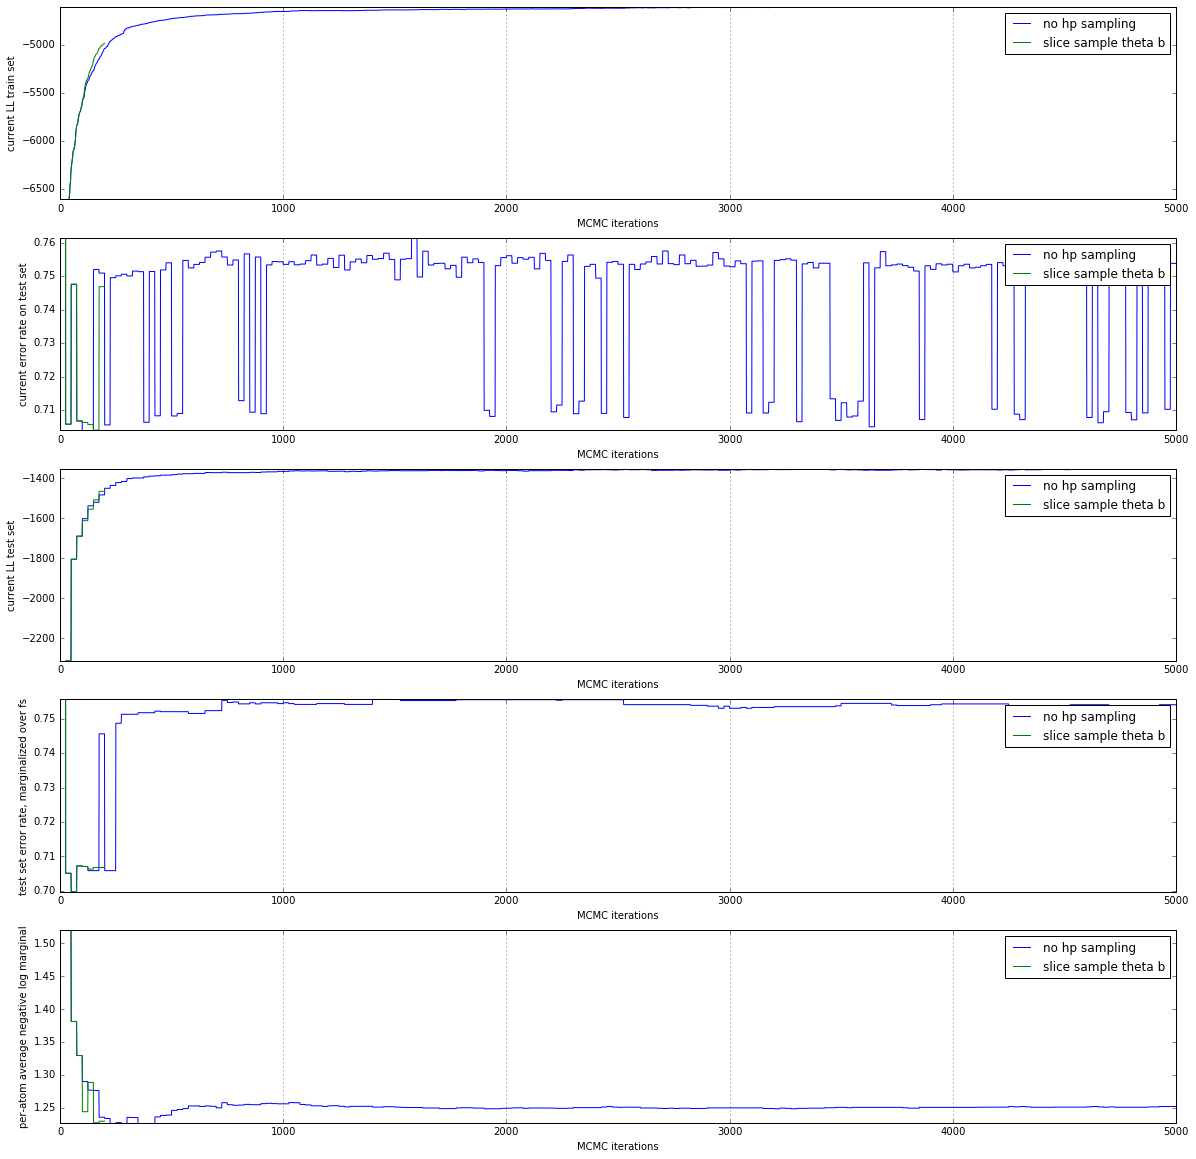

In [61]:
import util_experiments
util_experiments.make_figure(range(5), 
                             [
        ('no hp sampling', '/xvdb/results-2015-11-19-ard.protein/pygpstruct_50k.task=protein.hp_sampling_mode=None.kernel=kernel_linear_ard.parameterization=custom.fold=?.hp_sampling_thinning=100/results.bin' ),
        ('slice sample theta b', '/xvdb/results-2015-11-19-ard.protein/pygpstruct_50k.task=protein.hp_sampling_mode=slice sample theta.kernel=kernel_linear_ard.parameterization=custom.fold=?.hp_sampling_thinning=100/results.bin' ),
                             ])

## train==test set: learning happens !

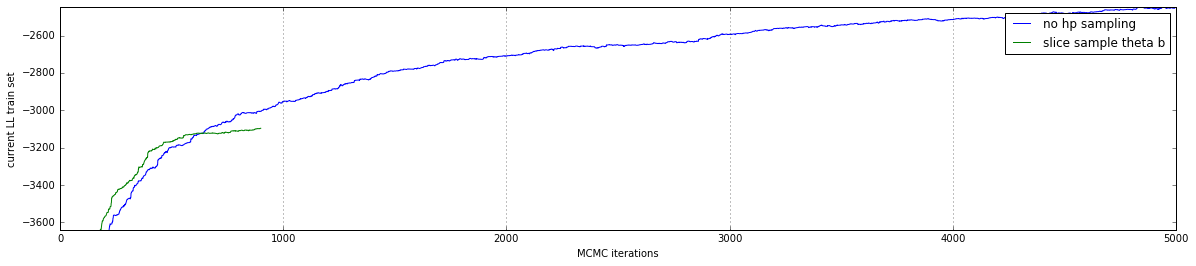

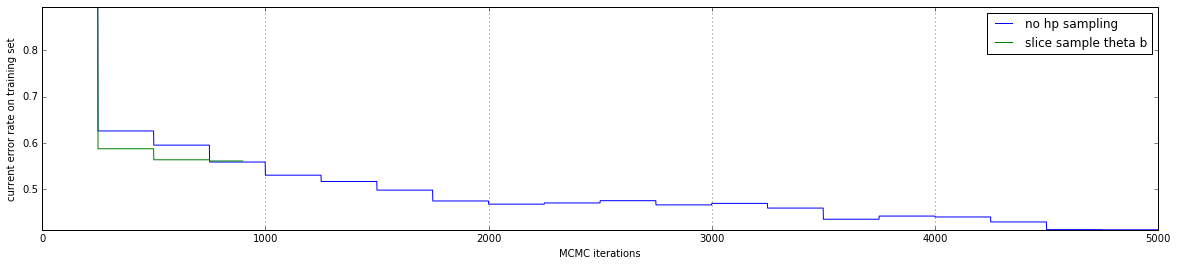

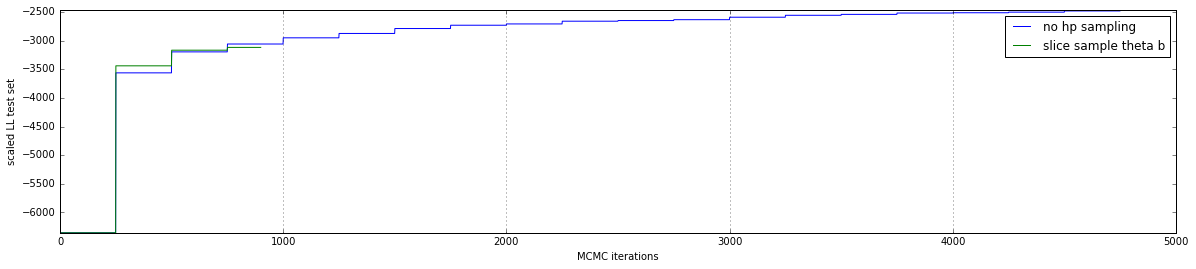

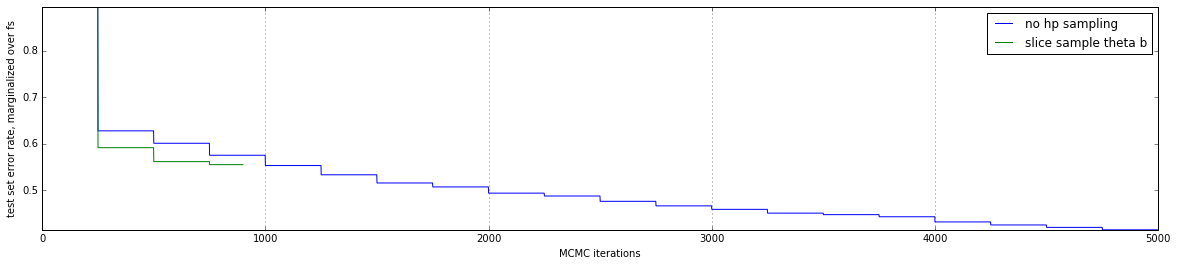

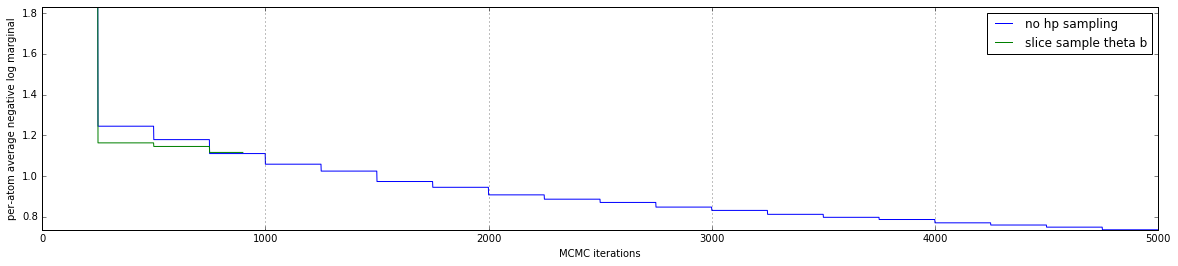

In [54]:
import util_experiments
util_experiments.make_figure(range(5), 
                             [
        ('no hp sampling', '/xvdb/results-2015-11-19-ard.protein/pygpstruct_50k.task=protein.hp_sampling_mode=None.kernel=kernel_exponential_ard.parameterization=custom.fold=?.hp_sampling_thinning=100/results.bin' ),
        ('slice sample theta b', '/xvdb/results-2015-11-19-ard.protein/pygpstruct_50k.task=protein.hp_sampling_mode=slice sample theta.kernel=kernel_exponential_ard.parameterization=custom.fold=?.hp_sampling_thinning=100/results.bin' ),
                             ])

## train != test, kernel=exponential_ard

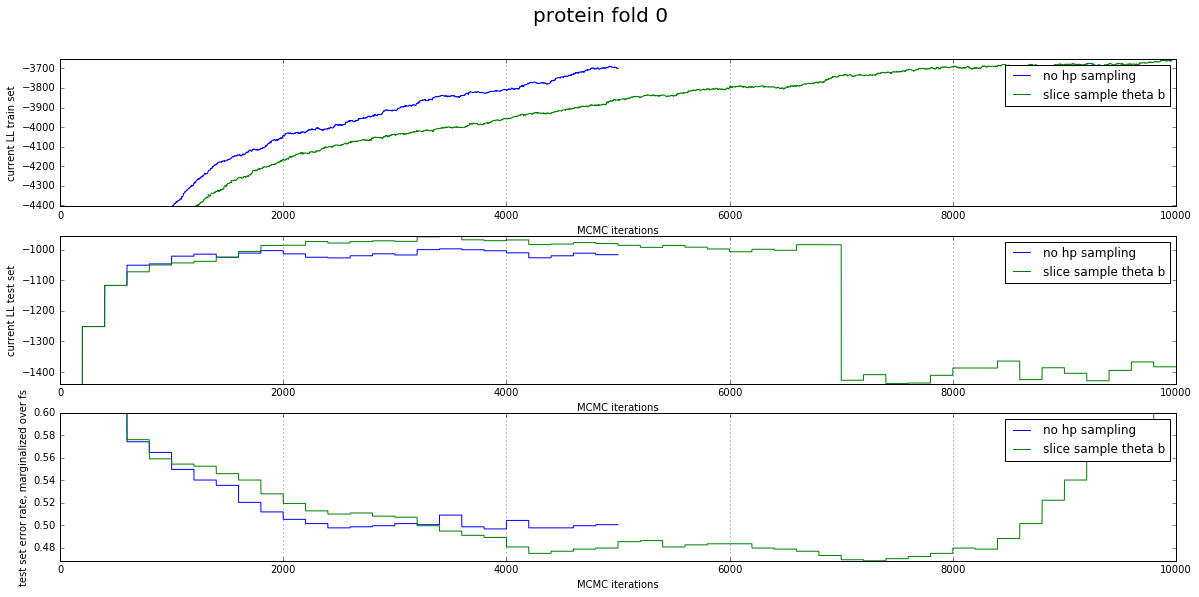

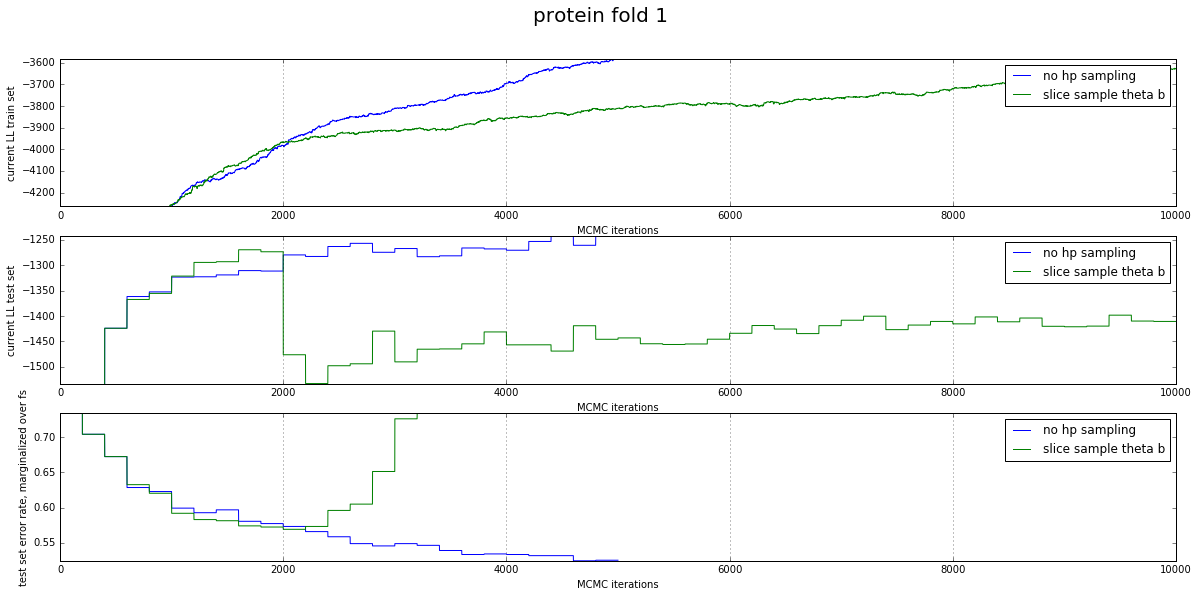

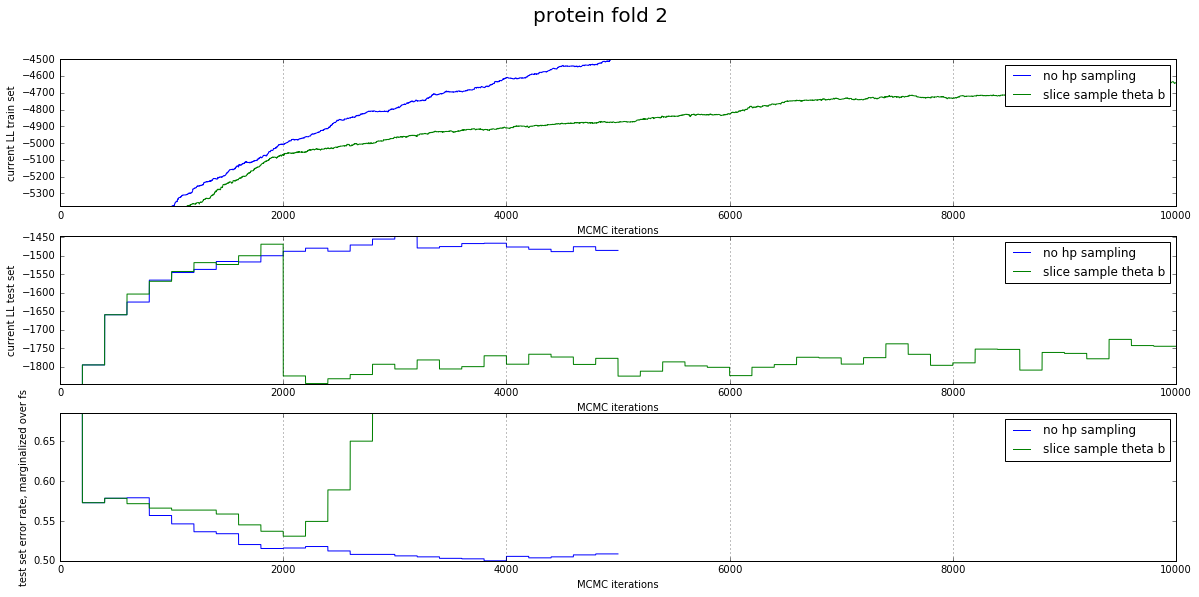

In [3]:
import util_experiments
for fold in range(3):
    util_experiments.make_figure([0,2,3], 
                             [
        ('no hp sampling', '/xvdb/results-2015-11-19-ard.protein/pygpstruct_50k.task=protein.hp_sampling_mode=None.kernel=kernel_exponential_ard.parameterization=custom.fold=%g.hp_sampling_thinning=500/results.bin' % fold),
        ('slice sample theta b', '/xvdb/results-2015-11-19-ard.protein/pygpstruct_50k.task=protein.hp_sampling_mode=slice sample theta.kernel=kernel_exponential_ard.parameterization=custom.fold=%g.hp_sampling_thinning=500/results.bin' %fold ),
                             ],
                                pdf_filename='/xvdb/tmp/protein.fold=%g.pdf' % fold,
                                title='protein fold %g' % fold)

In [28]:
k = np.load('/xvdb/results-2015-11-19-ard.protein/pygpstruct_50k.task=protein.hp_sampling_mode=slice sample theta.kernel=kernel_exponential_ard.parameterization=custom.fold=0.hp_sampling_thinning=100/last_kernel.npz')

In [34]:
k['lower_chol_k_unary'].shape

(1823, 1823)

In [32]:
k.items()

[('lower_chol_k_unary',
  array([[  1.000e+00,   0.000e+00,   0.000e+00, ...,   0.000e+00,
            0.000e+00,   0.000e+00],
         [  2.214e-02,   9.998e-01,   0.000e+00, ...,   0.000e+00,
            0.000e+00,   0.000e+00],
         [  7.219e-03,   4.187e-02,   9.991e-01, ...,   0.000e+00,
            0.000e+00,   0.000e+00],
         ..., 
         [  4.086e-02,   1.146e-01,   4.281e-02, ...,   5.772e-01,
            0.000e+00,   0.000e+00],
         [  7.794e-03,   3.745e-02,   1.378e-01, ...,  -9.068e-04,
            6.221e-01,   0.000e+00],
         [  1.513e-02,   6.365e-02,   1.450e-01, ...,  -3.013e-03,
           -5.978e-04,   1.909e-01]]))]

In [40]:
gram_unary = k['lower_chol_k_unary'].dot(k['lower_chol_k_unary'].T)

<IPython.core.display.Javascript object>


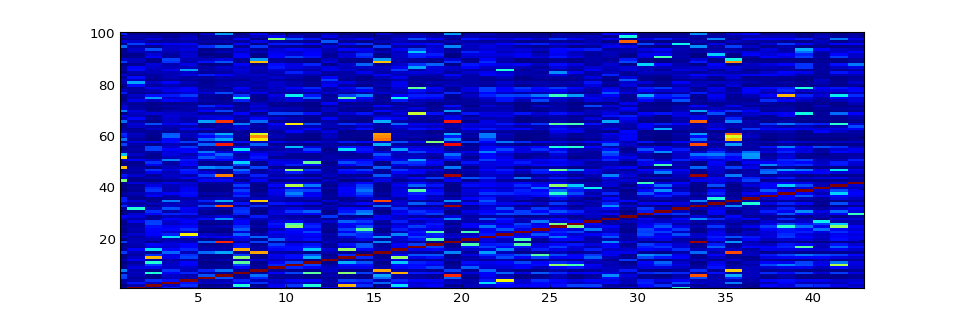

In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,4));
ax.pcolor(gram_unary[:500,:500])

In [42]:
gram_unary[:10][:10]

array([[ 1.   ,  0.022,  0.007, ...,  0.041,  0.008,  0.015],
       [ 0.022,  1.   ,  0.042, ...,  0.116,  0.038,  0.064],
       [ 0.007,  0.042,  1.   , ...,  0.048,  0.139,  0.148],
       ..., 
       [ 0.013,  0.059,  0.386, ...,  0.081,  0.112,  0.507],
       [ 0.249,  0.046,  0.013, ...,  0.093,  0.014,  0.023],
       [ 0.014,  0.087,  0.1  , ...,  0.084,  0.035,  0.045]])